In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

Load the Dataset

In [2]:
BASE_DIR = 'C:\\Users\\sarao\\Downloads\\Dataset\\UTKFace'

In [3]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  C:\Users\sarao\Downloads\Dataset\UTKFace\100_0...  100       0
1  C:\Users\sarao\Downloads\Dataset\UTKFace\100_0...  100       0
2  C:\Users\sarao\Downloads\Dataset\UTKFace\100_1...  100       1
3  C:\Users\sarao\Downloads\Dataset\UTKFace\100_1...  100       1
4  C:\Users\sarao\Downloads\Dataset\UTKFace\100_1...  100       1

In [7]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

EDA

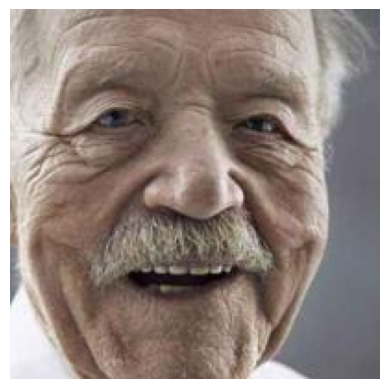

In [8]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

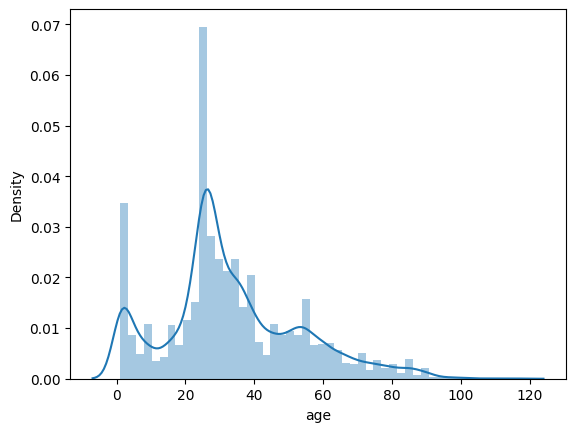

In [9]:
sns.distplot(df['age'])

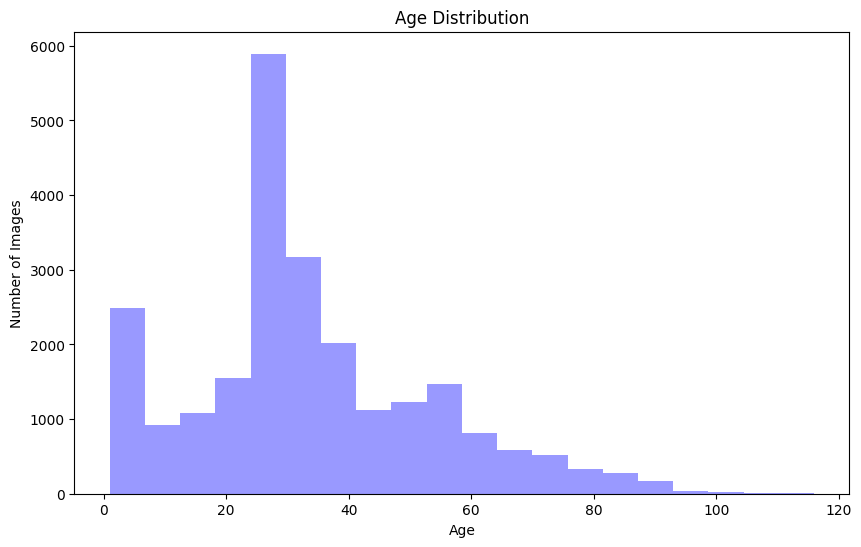

In [11]:
# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.distplot(df['age'], bins=20, kde=False, color='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Images')
plt.show()

In [16]:
# Define age groups
age_groups = {
    '0-10': range(0, 11),
    '11-20': range(11, 21),
    '21-30': range(21, 31),
    '31-40': range(31, 41),
    '41-50': range(41, 51),
    '51-60': range(51, 61),
    '61-70': range(61, 71),
    '71-80': range(71, 81),
    '81-90': range(81, 91),
    '91-100': range(91, 101)
}

# Count occurrences of each age group
age_counts = {group: 0 for group in age_groups}
for age in df['age']:
    for group, age_range in age_groups.items():
        if age in age_range:
            age_counts[group] += 1
            break

# Find the most frequent age group
most_frequent_age_group = max(age_counts, key=age_counts.get)
most_frequent_count = age_counts[most_frequent_age_group]

print("The most frequent age group in the dataset is:", most_frequent_age_group)
print("Number of occurrences:", most_frequent_count)

The most frequent age group in the dataset is: 21-30
Number of occurrences: 7784


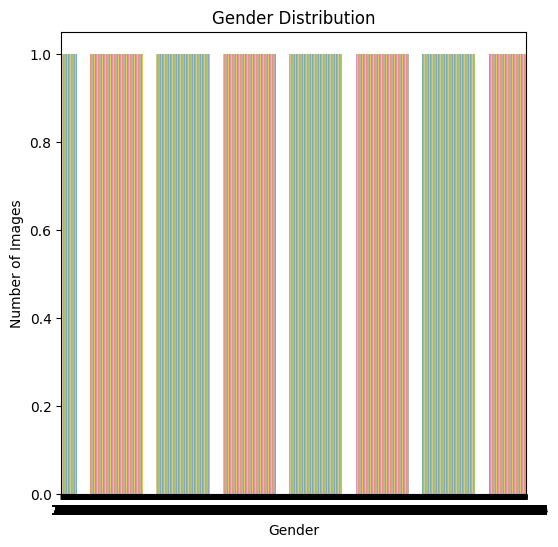

In [12]:
# Visualize gender distribution
plt.figure(figsize=(6, 6))
sns.countplot(df['gender'], palette='Set2')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of Images')
plt.show()

In [18]:
# Count the number of male and female pictures
male_count = (df['gender'] == 0).sum()
female_count = (df['gender'] == 1).sum()

# Print the results
if male_count > female_count:
    print("There are more pictures of males.")
    print("Number of male pictures:", male_count)
    print("Number of female pictures:", female_count)
elif female_count > male_count:
    print("There are more pictures of females.")
    print("Number of male pictures:", male_count)
    print("Number of female pictures:", female_count)
else:
    print("There are an equal number of pictures of males and females.")
    print("Number of male pictures:", male_count)
    print("Number of female pictures:", female_count)

There are more pictures of males.
Number of male pictures: 12391
Number of female pictures: 11317


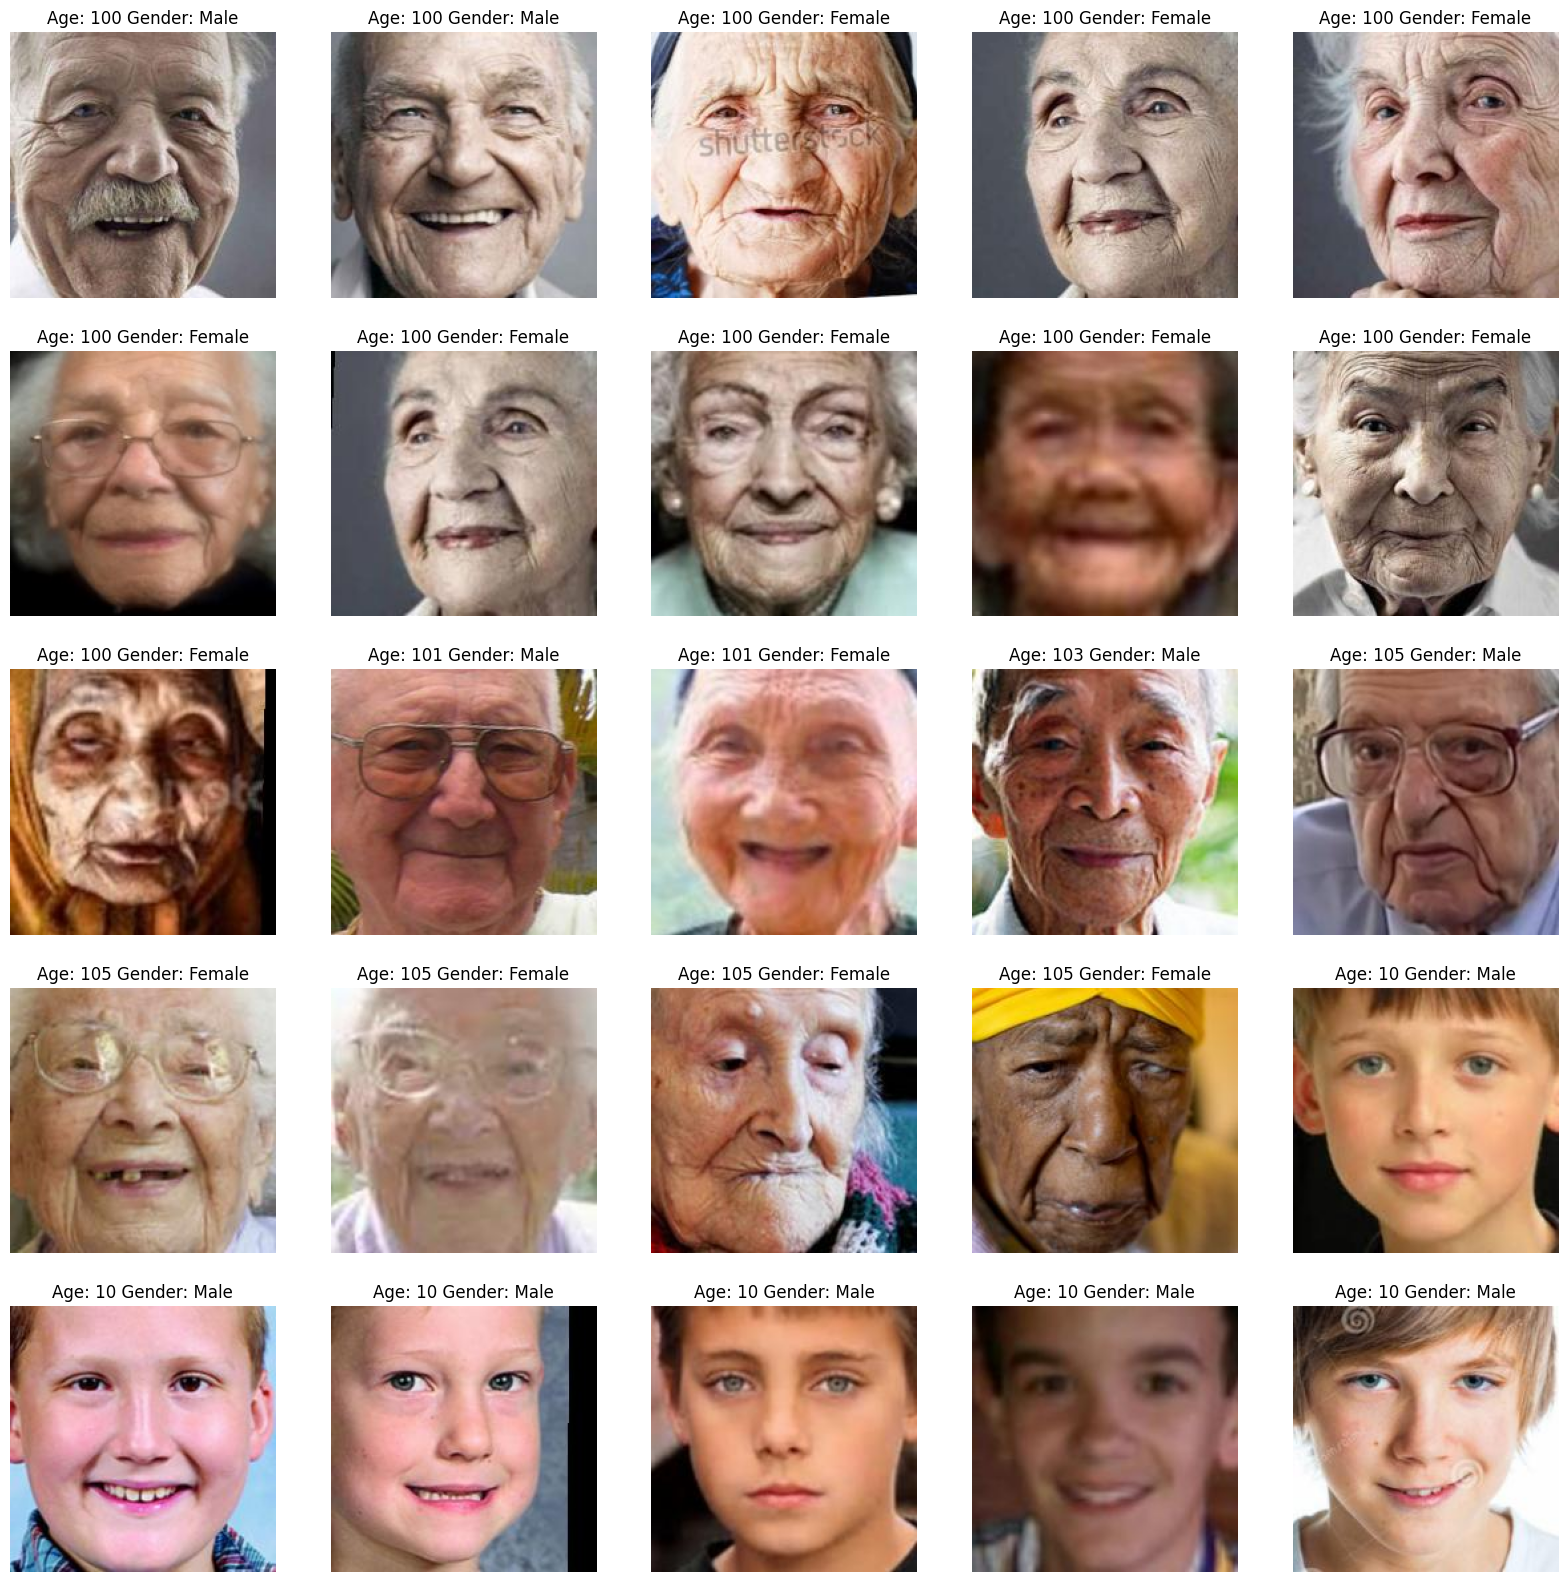

In [13]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

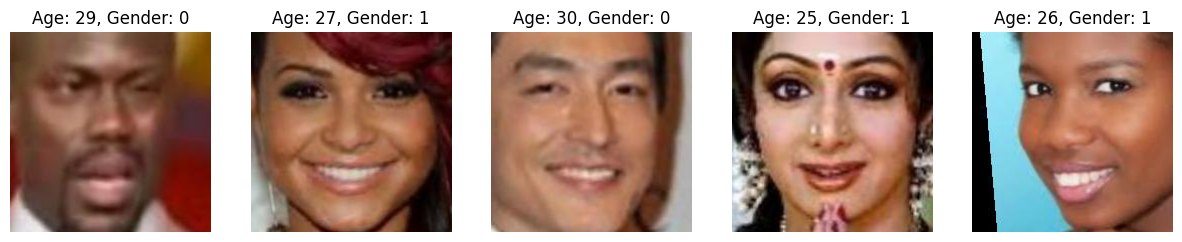

In [14]:
import random

# Filter the DataFrame for ages between 20 and 40 and both genders
filtered_df = df[(df['age'] >= 20) & (df['age'] <= 40)]

# Select random samples from the filtered DataFrame
num_samples = 5  # Number of random samples to display
random_samples = filtered_df.sample(n=num_samples)

# Plot random samples
plt.figure(figsize=(15, 10))
for i, (_, row) in enumerate(random_samples.iterrows(), 1):
    img = Image.open(row['image'])
    plt.subplot(1, num_samples, i)
    plt.imshow(img)
    plt.title(f"Age: {row['age']}, Gender: {row['gender']}")
    plt.axis('off')

plt.show()

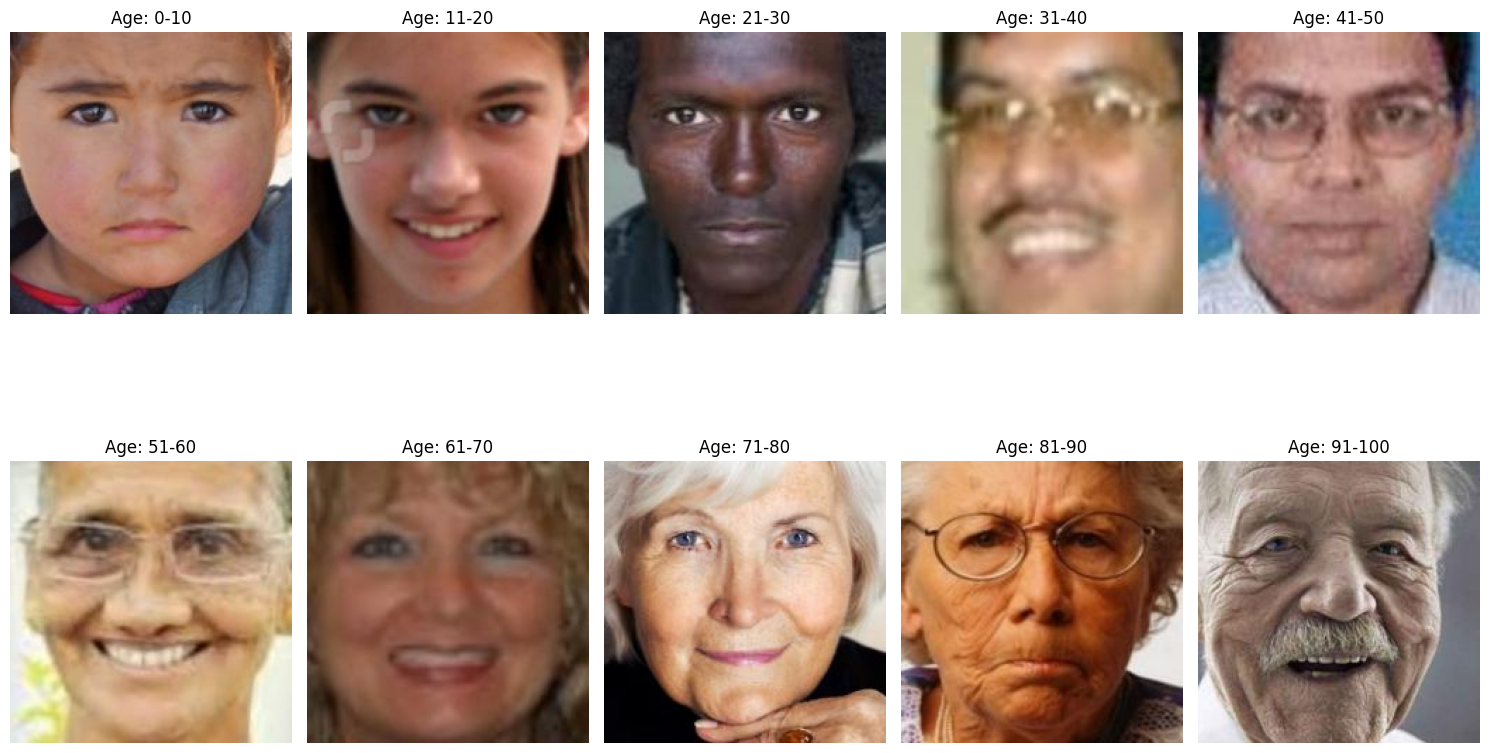

In [19]:
import random

# Define age groups
age_groups = [
    (0, 10),
    (11, 20),
    (21, 30),
    (31, 40),
    (41, 50),
    (51, 60),
    (61, 70),
    (71, 80),
    (81, 90),
    (91, 100)
]

# Plot random samples for each age group
plt.figure(figsize=(15, 10))

for i, (start_age, end_age) in enumerate(age_groups, 1):
    # Filter DataFrame for the current age group
    filtered_df = df[(df['age'] >= start_age) & (df['age'] <= end_age)]
    
    # Select a random sample from the filtered DataFrame
    random_sample = filtered_df.sample(n=1)
    img_path = random_sample['image'].values[0]
    img = Image.open(img_path)
    
    # Plot the image
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f"Age: {start_age}-{end_age}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Feature Extraction

In [22]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128)) 
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [23]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [24]:
X.shape

(23708, 128, 128, 1)

In [25]:
# normalize the images
X = X/255.0

In [26]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [27]:
input_shape = (128, 128, 1)

Model Creation

In [28]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [29]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 254s 416ms/step - age_out_mae: 11.6817 - gender_out_accuracy: 0.5171 - loss: 12.4167 - val_age_out_mae: 36.5526 - val_gender_out_accuracy: 0.6468 - val_loss: 37.2368
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 216s 365ms/step - age_out_mae: 9.1419 - gender_out_accuracy: 0.6730 - loss: 9.7362 - val_age_out_mae: 30.7621 - val_gender_out_accuracy: 0.7661 - val_loss: 31.2529
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 220s 371ms/step - age_out_mae: 7.4078 - gender_out_accuracy: 0.8039 - loss: 7.8298 - val_age_out_mae: 28.9808 - val_gender_out_accuracy: 0.7457 - val_loss: 29.4717
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 260s 438ms/step - age_out_mae: 6.8739 - gender_out_accuracy: 0.8239 - loss: 7.2530 - val_age_out_mae: 29.1185 - val_gender_out_accuracy: 0.7623 - val_loss: 29.6037
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 229s 386ms/step - age_out_mae: 6.5569 - gender_out_accuracy: 0.8396 - loss: 6.9076 - val_age_out_mae: 26.6425 - val_gender_out_accuracy: 0.783

Plot the Results

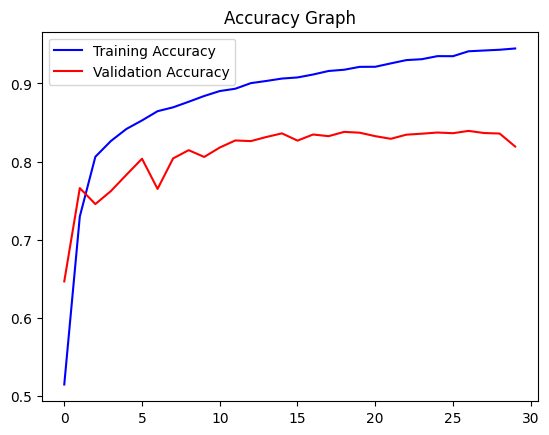

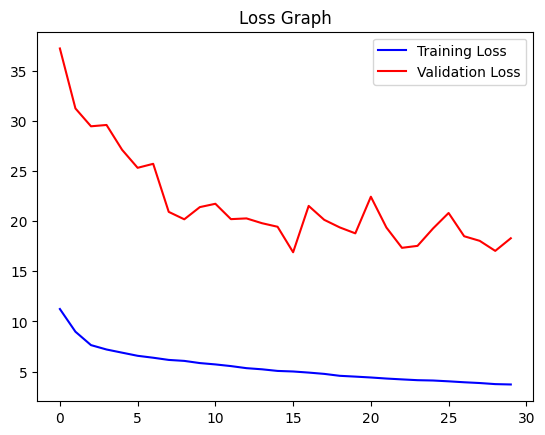

In [30]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

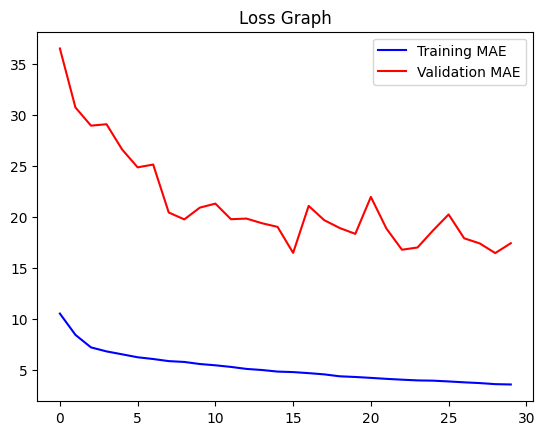

In [38]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Prediction with Test Data

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
Predicted Gender: Male Predicted Age: 6


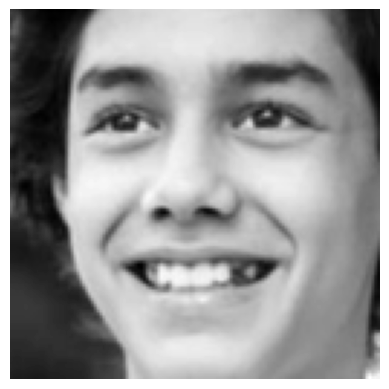

In [32]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Gender: Female Predicted Age: 36


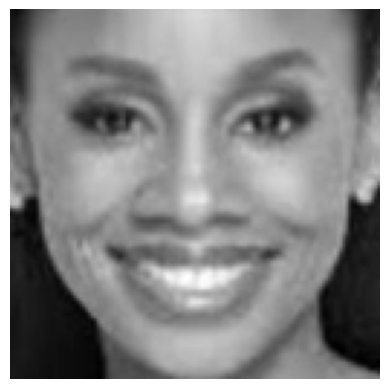

In [37]:
image_index = 15000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted Gender: Female Predicted Age: 28


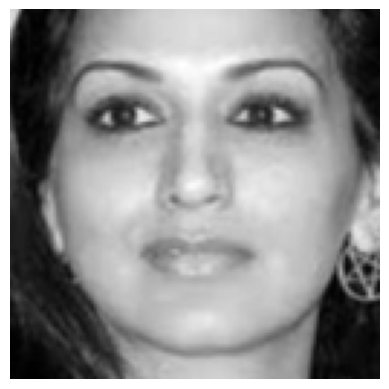

In [34]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')